In [1]:
import pandas as pd

In [2]:
online = pd.read_csv('../DATASETS/part3/chapter2/online12M.csv')

In [3]:
online['TotalSum'] = online['Quantity']*online['UnitPrice']

In [4]:
online['InvoiceDate'] = pd.to_datetime(online['InvoiceDate'])

In [5]:
from datetime import datetime

In [6]:
snapshot_date = pd.Timestamp(2012,12,10)
snapshot_date

Timestamp('2012-12-10 00:00:00')

In [7]:
datamart = online.groupby(['CustomerID']).agg({
    'InvoiceDate':lambda x: (snapshot_date - x.max()).days,
    'InvoiceNo':'count',
    'TotalSum':'sum'
})

In [8]:
datamart.rename(columns={
    'InvoiceDate':'Recency',
    'InvoiceNo':'Frequency',
    'TotalSum':'MonetaryValue'
}, inplace=True)

In [9]:
# Create labels for Recency and Frequency
r_labels = range(3, 0, -1); f_labels = range(1,4)

# Assign these labels to three equal percentile groups 
r_groups = pd.qcut(datamart['Recency'], q=3, labels=r_labels)

# Assign these labels to three equal percentile groups 
f_groups = pd.qcut(datamart['Frequency'], q=3, labels=f_labels)

# Create new columns R and F 
datamart = datamart.assign(R=r_groups.values, F=f_groups.values)

In [10]:
# Create labels for MonetaryValue
m_labels = range(1, 4)

# Assign these labels to three equal percentile groups 
m_groups = pd.qcut(datamart['MonetaryValue'], q=3, labels=m_labels)

# Create new column M
datamart = datamart.assign(M=m_groups.values)

# Calculate RFM_Score
datamart['RFM_Score'] = datamart[['R','F','M']].sum(axis=1)
print(datamart['RFM_Score'].head())

CustomerID
12747    9.0
12748    9.0
12749    9.0
12820    9.0
12822    6.0
Name: RFM_Score, dtype: float64


In [11]:
def join_rfm(x):
    return str(x['R']) + str(x['F']) +  str(x['M'])

In [12]:
datamart['RFM_Segment'] = datamart.apply(join_rfm, axis=1)

In [13]:
datamart.head()

,Recency,Frequency,MonetaryValue,R,F,M,RFM_Score,RFM_Segment
CustomerID,,,,,,,,
12747,369,25,948.70,3,3,3,9.0,333
12748,367,888,7046.16,3,3,3,9.0,333
12749,370,37,813.45,3,3,3,9.0,333
12820,370,17,268.02,3,3,3,9.0,333
12822,437,9,146.15,2,2,2,6.0,222


In [14]:
# Define rfm_level function
def rfm_level(df):
    if df['RFM_Score'] >= 10:
        return 'Top'
    elif ((df['RFM_Score'] >= 6) and (df['RFM_Score'] < 10)):
        return 'Middle'
    else:
        return 'Low'

# Create a new variable RFM_Level
datamart['RFM_Level'] = datamart.apply(rfm_level, axis=1)

# Print the header with top 5 rows to the console
print(datamart.head())

            Recency  Frequency  MonetaryValue  R  F  M  RFM_Score RFM_Segment  \
CustomerID                                                                      
12747           369         25         948.70  3  3  3        9.0         333   
12748           367        888        7046.16  3  3  3        9.0         333   
12749           370         37         813.45  3  3  3        9.0         333   
12820           370         17         268.02  3  3  3        9.0         333   
12822           437          9         146.15  2  2  2        6.0         222   

           RFM_Level  
CustomerID            
12747         Middle  
12748         Middle  
12749         Middle  
12820         Middle  
12822         Middle  


In [15]:
# Calculate average values for each RFM_Level, and return a size of each segment 
rfm_level_agg = datamart.groupby('RFM_Level').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
  
  	# Return the size of each segment
    'MonetaryValue': ['mean', 'count']
}).round(1)

# Print the aggregated dataset
print(rfm_level_agg)


          Recency Frequency MonetaryValue      
             mean      mean          mean count
RFM_Level                                      
Low         519.4       4.4          86.9  1627
Middle      405.6      30.2         599.7  2016


# normalizing data
supervised learning in general works better when the data is statistically unskewed. we may transform the data by taking the log value or modifying it by subtractin or dividing with its statistical values such as mean or std.

In [16]:
data = datamart[['Recency','Frequency','MonetaryValue']]

In [17]:
# Center the data by subtracting average values from each entry
rfm_centered = data - data.mean()

# Scale the data by dividing each entry by standard deviation
data_scaled = data / data.std()

# Normalize the data by applying both centering and scaling
data_normalized = (data - data.mean()) / data.std()

# Print summary statistics to make sure average is zero and standard deviation is one
print(data_normalized.describe().round(2))

       Recency  Frequency  MonetaryValue
count  3643.00    3643.00        3643.00
mean     -0.00      -0.00           0.00
std       1.00       1.00           1.00
min      -0.95      -0.40          -0.27
25%      -0.76      -0.34          -0.23
50%      -0.42      -0.22          -0.17
75%       0.51       0.05          -0.03
max       2.91      33.79          35.39


In [18]:
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [19]:
scaler = StandardScaler()
scaler.fit(data)
data_normalized = scaler.transform(data)

data_normalized = pd.DataFrame(data_normalized, index = data.index, columns = data.columns)

print(data_normalized.describe())

            Recency     Frequency  MonetaryValue
count  3.643000e+03  3.643000e+03   3.643000e+03
mean  -2.945154e-16 -7.801732e-18   2.047955e-17
std    1.000137e+00  1.000137e+00   1.000137e+00
min   -9.470748e-01 -4.049113e-01  -2.746647e-01
25%   -7.564645e-01 -3.363375e-01  -2.315735e-01
50%   -4.176019e-01 -2.220477e-01  -1.739268e-01
75%    5.142703e-01  5.224763e-02  -2.697655e-02
max    2.907488e+00  3.379058e+01   3.539755e+01


In [20]:
# Unskew the data
datamart_log = np.log(data)

# Initialize a standard scaler and fit it
scaler = StandardScaler()
scaler.fit(datamart_log)

# Scale and center the data
datamart_normalized = scaler.transform(datamart_log)

# Create a pandas DataFrame
datamart_normalized = pd.DataFrame(data=datamart_normalized, index=data.index, columns=data.columns)
print(data_normalized.describe().round(2))

       Recency  Frequency  MonetaryValue
count  3643.00    3643.00        3643.00
mean     -0.00      -0.00           0.00
std       1.00       1.00           1.00
min      -0.95      -0.40          -0.27
25%      -0.76      -0.34          -0.23
50%      -0.42      -0.22          -0.17
75%       0.51       0.05          -0.03
max       2.91      33.79          35.40


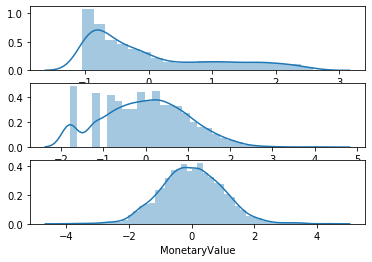

In [21]:
# Plot recency distribution
plt.subplot(3, 1, 1); sns.distplot(datamart_normalized['Recency'])

# Plot frequency distribution
plt.subplot(3, 1, 2); sns.distplot(datamart_normalized['Frequency'])

# Plot monetary value distribution
plt.subplot(3, 1, 3); sns.distplot(datamart_normalized['MonetaryValue'])

# Show the plot
plt.show()

# KMEANS

In [22]:
# Import KMeans 
from sklearn.cluster import KMeans

# Initialize KMeans
kmeans = KMeans(n_clusters=3, random_state=1) 

# Fit k-means clustering on the normalized data set
kmeans.fit(datamart_normalized)

# Extract cluster labels
cluster_labels = kmeans.labels_
print(cluster_labels)

[1 1 1 ... 0 1 1]


In [23]:
datamart_rfm = datamart_normalized

In [24]:
# Create a DataFrame by adding a new cluster label column
datamart_rfm_k3 = datamart_rfm.assign(Cluster=cluster_labels)

# Group the data by cluster
grouped = datamart_rfm_k3.groupby(['Cluster'])

# Calculate average RFM values and segment sizes per cluster value
grouped.agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
  }).round(1)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0          -0.4      -0.5          -0.5  1323
1          -0.6       0.9           0.9  1430
2           1.5      -0.8          -0.7   890

## choosing number of clusters
one way is to use elbow criterion method. the method compare the sum of squared error of each centrum for different number of clusters. pick one which has optimum error value

In [25]:
# Fit KMeans and calculate SSE for each k
sse = {}
for k in range(1, 21):
  
    # Initialize KMeans with k clusters
    kmeans = KMeans(n_clusters=k, random_state=1)
    
    # Fit KMeans on the normalized dataset
    kmeans.fit(data_normalized)
    
    # Assign sum of squared distances to k element of dictionary
    sse[k] = kmeans.inertia_

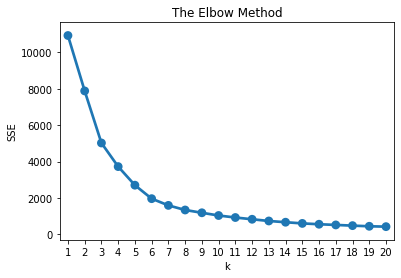

In [26]:
# Add the plot title "The Elbow Method"
plt.title('The Elbow Method')

# Add X-axis label "k"
plt.xlabel('k')

# Add Y-axis label "SSE"
plt.ylabel('SSE')

# Plot SSE values for each key in the dictionary
sns.pointplot(x=list(sse.keys()), y=list(sse.values()))
plt.show()

## profiling and interpreting segments 
ways to build persona
1. check the statistical summary
2. creating snake plots
3. importances between clusters

In [27]:
datamart_normalized.describe()

,Recency,Frequency,MonetaryValue
count,3.643000e+03,3.643000e+03,3.643000e+03
mean,5.525577e-15,2.282007e-16,3.666814e-16
std,1.000137e+00,1.000137e+00,1.000137e+00
min,-1.050802e+00,-1.794731e+00,-4.093550e+00
25%,-7.980610e-01,-6.491795e-01,-6.579180e-01
50%,-3.766127e-01,2.092505e-02,-1.489805e-02
75%,6.340678e-01,7.210817e-01,6.692948e-01
max,2.586337e+00,4.246826e+00,4.459466e+00


In [29]:
# Melt the normalized dataset and reset the index
datamart_melt = pd.melt(datamart_rfm_k3.reset_index(), 
                        
# Assign CustomerID and Cluster as ID variables
                    id_vars=['CustomerID', 'Cluster'],

# Assign RFM values as value variables
                    value_vars=['Recency', 'Frequency', 'MonetaryValue'], 
                        
# Name the variable and value
                    var_name='Metric', value_name='Value')

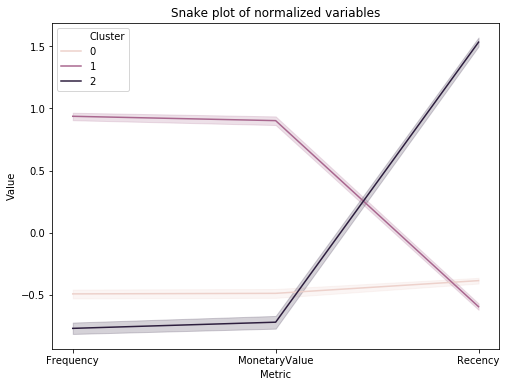

In [30]:
# Add the plot title
plt.figure(figsize=(8,6))
plt.title('Snake plot of normalized variables')

# Add the x axis label
plt.xlabel('Metric')

# Add the y axis label
plt.ylabel('Value')

# Plot a line for each value of the cluster variable
sns.lineplot(data=datamart_melt, x='Metric', y='Value', hue='Cluster')
plt.show()

In [33]:
# Calculate average RFM values for each cluster
cluster_avg = datamart_rfm_k3.groupby(['Cluster']).mean() 

# Calculate average RFM values for the total customer population
population_avg = datamart_rfm.mean()

print(cluster_avg)
print(population_avg)

# Calculate relative importance of cluster's attribute value compared to population
relative_imp = cluster_avg / population_avg - 1

# Print relative importance scores rounded to 2 decimals
print(relative_imp.round(2))

          Recency  Frequency  MonetaryValue
Cluster                                    
0       -0.386962  -0.493829      -0.489429
1       -0.597026   0.937065       0.902071
2        1.534491  -0.771537      -0.721850
Recency          5.465997e-15
Frequency        1.724152e-16
MonetaryValue    3.223700e-16
dtype: float64
              Recency     Frequency  MonetaryValue
Cluster                                           
0       -7.079433e+13 -2.864183e+15  -1.518221e+15
1       -1.092254e+14  5.434932e+15   2.798246e+15
2        2.807340e+14 -4.474876e+15  -2.239198e+15


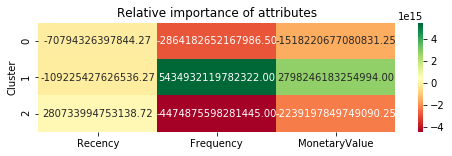

In [32]:
# Initialize a plot with a figure size of 8 by 2 inches 
plt.figure(figsize=(8,2))

# Add the plot title
plt.title('Relative importance of attributes')

# Plot the heatmap
sns.heatmap(data=relative_imp, annot=True, fmt='.2f', cmap='RdYlGn')
plt.show()